In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv('../data/processed/airline_passengers.csv', index_col='Month', parse_dates=True)

In [10]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


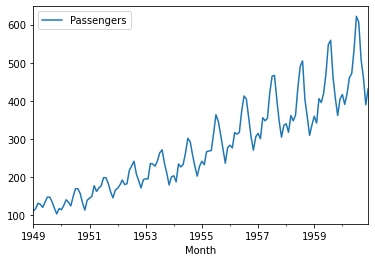

In [11]:
df.plot();

In [12]:
df['lstdiff'] = df['Passengers'].diff()

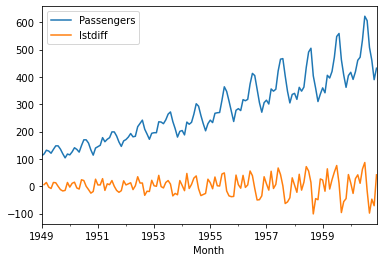

In [13]:
df.plot();

In [14]:
df['LogPassengers'] = np.log(df['Passengers'])

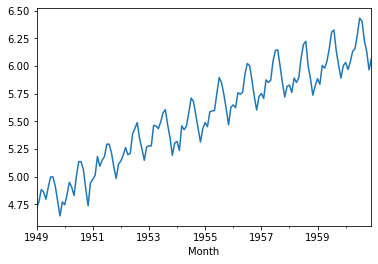

In [15]:
df['LogPassengers'].plot();

In [16]:
from statsmodels.tsa.arima_model import ARIMA

In [17]:
df.index.feq = 'MS'

Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [18]:
arima = ARIMA(train['Passengers'], order=(1,0,0))

In [19]:
arima_result = arima.fit()

In [20]:
df.loc[:-Ntest, 'AR(1)'] = arima_result.predict(start=train.index[0], end=train.index[-1])

<AxesSubplot:xlabel='Month'>

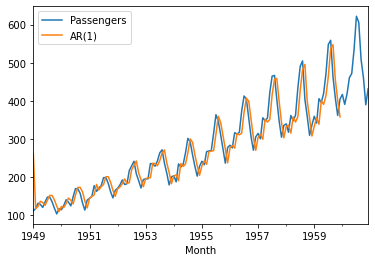

In [21]:
df[['Passengers', 'AR(1)']].plot();

In [23]:
forecast, stderrm, confint = arima_result.forecast(Ntest)
df.loc[-Ntest:, 'AR(1)'] = forecast

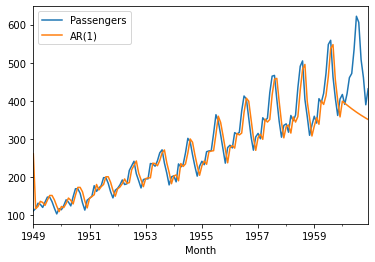

In [24]:
df[['Passengers', 'AR(1)']].plot();

In [40]:
def plot_fit_and_forecast(result):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df['Passengers'], label='data')

    # plot the curve fitted on train set
    train_pred = result.fittedvalues
    ax.plot(train.index, train_pred, color='green', label='fitted')

    # forecast the test set
    forecast, stderr, confint = result.forecast(Ntest)
    ax.plot(test.index, forecast, label='forecast')
    ax.fill_between(test.index, confint[:,0], confint[:,1], color='red', alpha=0.3)
    ax.legend()

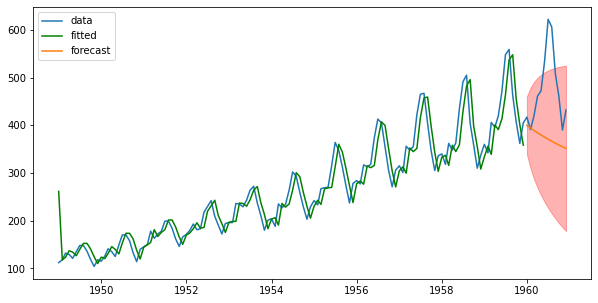

In [30]:
plot_fit_and_forecast(arima_result)

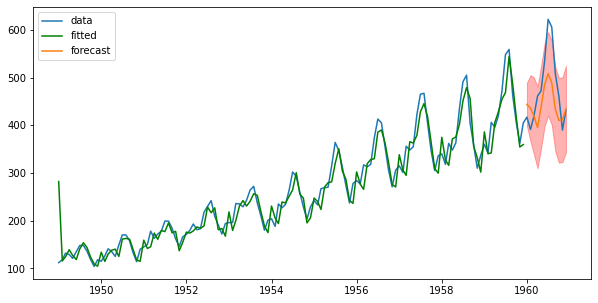

In [31]:
arima = ARIMA(train['Passengers'], order=(10,0,0)) # AR(10)
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)

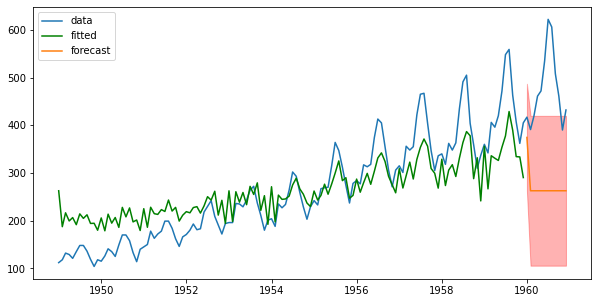

In [32]:
arima = ARIMA(train['Passengers'], order=(0,0,1)) # MA(1)
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)

In [35]:
df['LoglstDiff'] = df['LogPassengers'].diff()

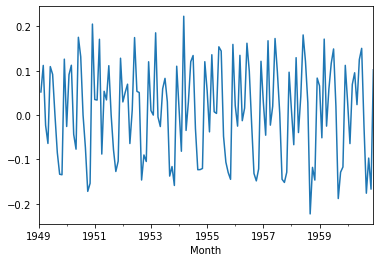

In [36]:
df['LoglstDiff'].plot();

In [43]:
arima = ARIMA(train['Passengers'], order=(8,1,1)) 
arima_result_811 = arima.fit()

def plot_fit_and_forecast_int(result, d, col='Passengers'):
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df[col], label='data')

    # plot the curve fitted on train set
    train_pred = result.predict(start=train.index[d], end=train.index[-1], typ='levels')
    ax.plot(train.index[d:], train_pred, color='green', label='fitted')

    # forecast the test set
    forecast, stderr, confint = result.forecast(Ntest)
    ax.plot(test.index, forecast, label='forecast')
    ax.fill_between(test.index, confint[:,0], confint[:,1], color='red', alpha=0.3)
    ax.legend()

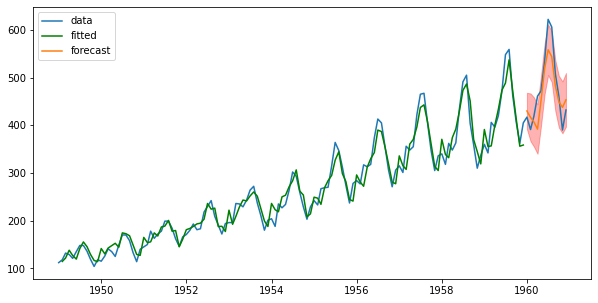

In [44]:
plot_fit_and_forecast_int(arima_result_811, 1)

In [48]:
def plot_difference(result, d, col='Passengers'):
    train_pred = result.predict(start=train.index[d], end=train.index[-1])
    # train_pred = result.fittedvalues
    diff = df[col].diff()
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(diff, label='true 1st difference')
    ax.plot(train_pred, label='fitted 1st difference');

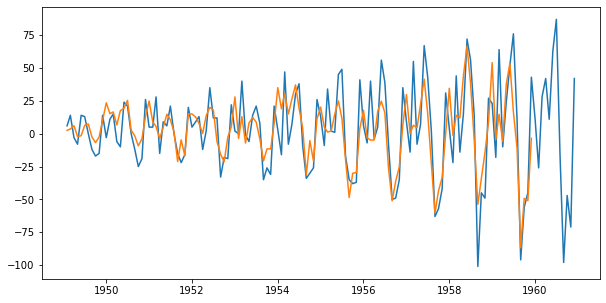

In [49]:
plot_difference(arima_result_811, 1)

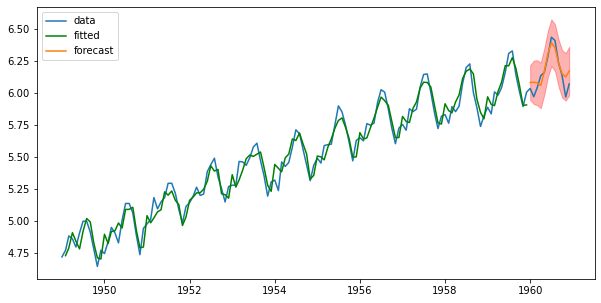

In [50]:
arima = ARIMA(train['LogPassengers'], order=(8,1,1)) 
arima_result_log811 = arima.fit()
plot_fit_and_forecast_int(arima_result_log811, 1, col='LogPassengers')

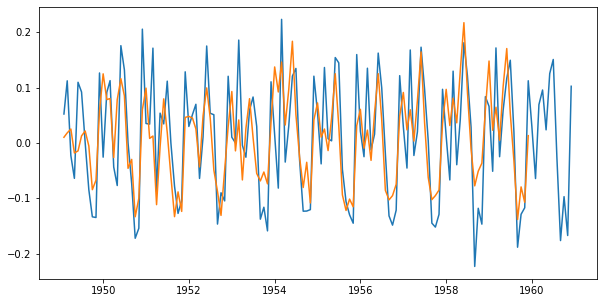

In [52]:
plot_difference(arima_result_log811, 1, col='LogPassengers')

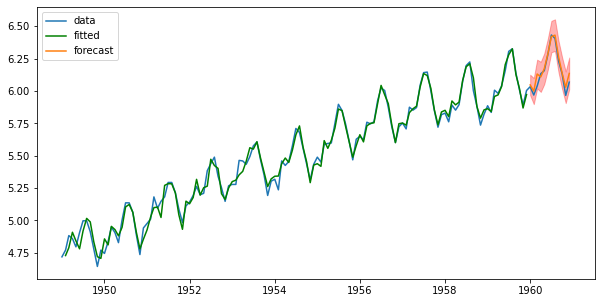

In [53]:
arima = ARIMA(train['LogPassengers'], order=(12,1,0)) 
arima_result_log1210 = arima.fit()
plot_fit_and_forecast_int(arima_result_log1210, 1, col='LogPassengers')

In [54]:
def rmse(result, is_logged):
    forecast, stderr, confnt = result.forecast(Ntest)
    if is_logged:
        forecast = np.exp(forecast)

    t = test['Passengers']
    y = forecast
    return np.sqrt(np.mean((t - y)**2))

In [56]:
print("ARIMA(8, 1, 1):", rmse(arima_result_811, False))
print("ARIMA(8, 1, 1) logged:", rmse(arima_result_log811, True))
print("ARIMA(12, 1, 0) logged:", rmse(arima_result_log1210, True))

ARIMA(8, 1, 1): 38.55066415936323
ARIMA(8, 1, 1) logged: 32.224014334073836
ARIMA(12, 1, 0) logged: 18.612513290103184
